- 以下 gmm, tsne（別ファイルに移す？）
- plain_tsne = tsne_df(dim 違うから注意)

In [110]:
## create gwbowv
from sklearn.feature_extraction.text import TfidfVectorizer,HashingVectorizer
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

def cluster_GMM(num_clusters, word_vectors):
    # Initalize a GMM object and use it for clustering.
    clf =  GaussianMixture(n_components=num_clusters,
                    covariance_type="tied", init_params='kmeans', max_iter=50)
    # Get cluster assignments.
    clf.fit(word_vectors)
    idx = clf.predict(word_vectors)
    print ("Clustering Done...", time.time()-start, "seconds")
    # Get probabilities of cluster assignments.
    idx_proba = clf.predict_proba(word_vectors)
    # Dump cluster assignments and probability of cluster assignments. 
    pickle.dump(idx, open('../../model/gmm_latestclusmodel_len2alldata.pkl',"wb"))
    print ("Cluster Assignments Saved...")

    pickle.dump(idx_proba,open( '../../model/gmm_prob_latestclusmodel_len2alldata.pkl',"wb"))
    print ("Probabilities of Cluster Assignments Saved...")
    return (idx, idx_proba)

def read_GMM(idx_name, idx_proba_name):
    # Loads cluster assignments and probability of cluster assignments. 
    idx = pickle.load(open('../../model/gmm_latestclusmodel_len2alldata.pkl',"rb"))
    idx_proba = pickle.load(open( '../../model/gmm_prob_latestclusmodel_len2alldata.pkl',"rb"))
    print ("Cluster Model Loaded...")
    return (idx, idx_proba)

def get_probability_word_vectors(featurenames, word_centroid_map, num_clusters, word_idf_dict):
    # This function computes probability word-cluster vectors
    prob_wordvecs = {}
    for word in word_centroid_map:
        prob_wordvecs[word] = np.zeros( num_clusters * num_features, dtype="float32" )
        for index in range(0, num_clusters):
            try:
                prob_wordvecs[word][index*num_features:(index+1)*num_features] = model[word] * word_centroid_prob_map[word][index] * word_idf_dict[word]
            except:
                continue

    # prob_wordvecs_idf_len2alldata = {}
    # i = 0
    # for word in featurenames:
    #     i += 1
    #     if word in word_centroid_map:    
    #         prob_wordvecs_idf_len2alldata[word] = {}
    #         for index in range(0, num_clusters):
    #                 prob_wordvecs_idf_len2alldata[word][index] = model[word] * word_centroid_prob_map[word][index] * word_idf_dict[word] 



    # for word in prob_wordvecs_idf_len2alldata.keys():
    #     prob_wordvecs[word] = prob_wordvecs_idf_len2alldata[word][0]
    #     for index in prob_wordvecs_idf_len2alldata[word].keys():
    #         if index==0:
    #             continue
    #         prob_wordvecs[word] = np.concatenate((prob_wordvecs[word], prob_wordvecs_idf_len2alldata[word][index]))
    return prob_wordvecs

def create_cluster_vector_and_gwbowv(prob_wordvecs, wordlist, word_centroid_map, word_centroid_prob_map, dimension, word_idf_dict, featurenames, num_centroids, train=False):
    # This function computes SDV feature vectors.
    bag_of_centroids = np.zeros( num_centroids * dimension, dtype="float32" )
    global min_no
    global max_no

    for word in wordlist:
        try:
            temp = word_centroid_map[word]
        except:
            continue

        bag_of_centroids += prob_wordvecs[word]

    norm = np.sqrt(np.einsum('...i,...i', bag_of_centroids, bag_of_centroids))
    if(norm!=0):
        bag_of_centroids /= norm

    # To make feature vector sparse, make note of minimum and maximum values.
    if train:
        min_no += min(bag_of_centroids)
        max_no += max(bag_of_centroids)

    return bag_of_centroids

In [111]:
num_features = 200     # Word vector dimensionality
min_word_count = 20   # Minimum word count
num_workers = 40       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

model_name = str(num_features) + "features_" + str(min_word_count) + "minwords_" + str(context) + "context_len2alldata"
# Load the trained Word2Vec model.
model = Word2Vec.load("../../model/"+model_name)
# Get wordvectors for all words in vocabulary.
word_vectors = model.wv.syn0

# Load train data.
train,test = train_test_split(df,test_size=0.3,random_state=40)
all = df

# Set number of clusters.
num_clusters = 60
idx, idx_proba = cluster_GMM(num_clusters, word_vectors)

# Create a Word / Index dictionary, mapping each vocabulary word to
# a cluster number
word_centroid_map = dict(zip( model.wv.index2word, idx ))
# Create a Word / Probability of cluster assignment dictionary, mapping each vocabulary word to
# list of probabilities of cluster assignments.
word_centroid_prob_map = dict(zip( model.wv.index2word, idx_proba ))

2019-10-13 19:33:43,857 : INFO : loading Word2Vec object from ../../model/200features_20minwords_10context_len2alldata
2019-10-13 19:33:44,069 : INFO : loading wv recursively from ../../model/200features_20minwords_10context_len2alldata.wv.* with mmap=None
2019-10-13 19:33:44,069 : INFO : setting ignored attribute vectors_norm to None
2019-10-13 19:33:44,070 : INFO : loading vocabulary recursively from ../../model/200features_20minwords_10context_len2alldata.vocabulary.* with mmap=None
2019-10-13 19:33:44,070 : INFO : loading trainables recursively from ../../model/200features_20minwords_10context_len2alldata.trainables.* with mmap=None
2019-10-13 19:33:44,071 : INFO : setting ignored attribute cum_table to None
2019-10-13 19:33:44,073 : INFO : loaded ../../model/200features_20minwords_10context_len2alldata
/Users/miori/.local/share/virtualenvs/miori-QT72LG3r/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning:

Call to deprecated `syn0` (Attribute will be removed 

Clustering Done... 2351.082633972168 seconds
Cluster Assignments Saved...
Probabilities of Cluster Assignments Saved...


In [112]:
# Computing tf-idf values.
traindata = []
for review in all["news"]:
    result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    traindata.append(" ".join(h))

tfv = TfidfVectorizer(dtype=np.float32)
tfidfmatrix_traindata = tfv.fit_transform(traindata)
featurenames = tfv.get_feature_names()
idf = tfv._tfidf.idf_

# Creating a dictionary with word mapped to its idf value 
print ("Creating word-idf dictionary for Training set...")

word_idf_dict = {}
for pair in zip(featurenames, idf):
    word_idf_dict[pair[0]] = pair[1]

Creating word-idf dictionary for Training set...


In [114]:
# gwbowv is a matrix which contains normalised document vectors.
gwbowv = np.zeros( (train["news"].size, num_clusters*(num_features)), dtype="float32")

counter = 0

min_no = 0
max_no = 0
for review in train["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = h
    gwbowv[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters, train=True)
    counter+=1
    if counter % 1000 == 0:
        print ("Train News Covered : ",counter)

gwbowv_name = "SDV_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

gwbowv_test = np.zeros( (test["news"].size, num_clusters*(num_features)), dtype="float32")

counter = 0

for review in test["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = h
    gwbowv_test[counter] = create_cluster_vector_and_gwbowv(prob_wordvecs, words, word_centroid_map, word_centroid_prob_map, num_features, word_idf_dict, featurenames, num_clusters)
    counter+=1
    if counter % 1000 == 0:
        print ("Test News Covered : ",counter)

test_gwbowv_name = "TEST_SDV_" + str(num_clusters) + "cluster_" + str(num_features) + "feature_matrix_gmm_sparse.npy"

print ("Making sparse...")
# Set the threshold percentage for making it sparse. 
percentage = 0.04
min_no = min_no*1.0/len(train["news"])
max_no = max_no*1.0/len(train["news"])
print ("Average min: ", min_no)
print ("Average max: ", max_no)
thres = (abs(max_no) + abs(min_no))/2
thres = thres*percentage

# Make values of matrices which are less than threshold to zero.
temp = abs(gwbowv) < thres
gwbowv[temp] = 0

temp = abs(gwbowv_test) < thres
gwbowv_test[temp] = 0

#saving gwbowv train and test matrices
np.save("../../model/"+gwbowv_name, gwbowv)
np.save("../../model/"+test_gwbowv_name, gwbowv_test)

Train News Covered :  1000
Train News Covered :  2000
Train News Covered :  3000
Train News Covered :  4000
Train News Covered :  5000
Test News Covered :  1000
Test News Covered :  2000
Making sparse...
Average min:  -0.12143216044277161
Average max:  0.12879189578173256


/Users/miori/.local/share/virtualenvs/miori-QT72LG3r/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



All News Covered :  1000
All News Covered :  2000
All News Covered :  3000
All News Covered :  4000
All News Covered :  5000
All News Covered :  6000
All News Covered :  7000
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7367 samples in 0.032s...
[t-SNE] Computed neighbors for 7367 samples in 17.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7367
[t-SNE] Computed conditional probabilities for sample 2000 / 7367
[t-SNE] Computed conditional probabilities for sample 3000 / 7367
[t-SNE] Computed conditional probabilities for sample 4000 / 7367
[t-SNE] Computed conditional probabilities for sample 5000 / 7367
[t-SNE] Computed conditional probabilities for sample 6000 / 7367
[t-SNE] Computed conditional probabilities for sample 7000 / 7367
[t-SNE] Computed conditional probabilities for sample 7367 / 7367
[t-SNE] Mean sigma: 0.032836
[t-SNE] Computed conditional probabilities in 0.253s
[t-SNE] Iteration 50: error = 91.9919662, gradient norm = 0.0140713 (50 i

/Users/miori/.local/share/virtualenvs/miori-QT72LG3r/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning:

The `size` paramter has been renamed to `height`; please update your code.



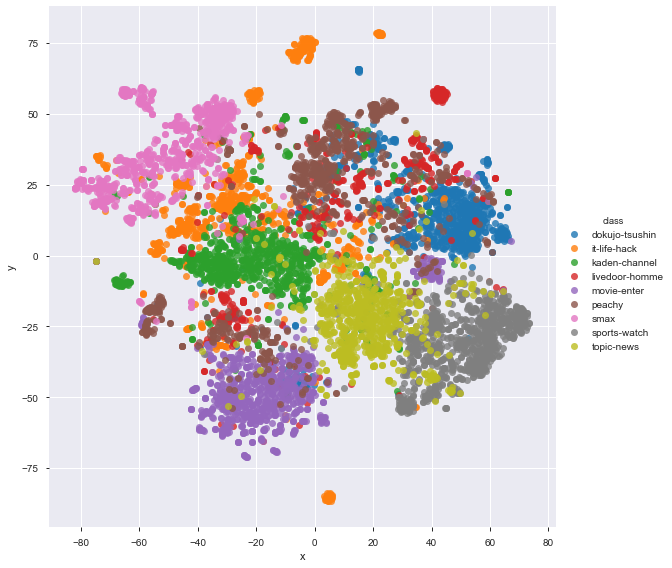

In [115]:
import seaborn as sns

#document vector visualization
## plain word2vec
def plain_word2vec_document_vector(sentence,word2vec_model,num_features):
    bag_of_centroids = np.zeros(num_features, dtype="float32")

    for word in sentence:
        try:
            temp = word2vec_model[word]
        except:
            continue
        bag_of_centroids += temp

    bag_of_centroids =  bag_of_centroids / len(sentence)

    return bag_of_centroids

plainDocVec_all = {}
counter = 0
num_features = 200

for review in all["news"]:
    # Get the wordlist in each news article.
    result = tokenizer.parse(review).replace("\u3000","").replace("\n","")
    result = re.sub(r'[0123456789０１２３４５６７８９！＠＃＄％＾＆\-|\\＊\“（）＿■×※⇒—●(：〜＋=)／*&^%$#@!~`){}…\[\]\"\'\”:;<>?＜＞？、。・,./『』【】「」→←○]+', "", result)
    h = result.split(" ")
    h = filter(("").__ne__, h)
    words = list(h)
    plainDocVec_all[counter] = plain_word2vec_document_vector(words,word2vec_model,num_features)
    counter+=1
    if counter % 1000 == 0:
        print ("All News Covered : ",counter)

## visualize all document vector
emb_tuple = tuple([plainDocVec_all[v] for v in plainDocVec_all.keys()])
X = np.vstack(emb_tuple)

plain_w2v_doc= TSNE(n_components=2, random_state=0,verbose=2)
np.set_printoptions(suppress=True)
plain_w2v_doc.fit(X)

alldoc_plainw2v_tsne = pd.DataFrame(plain_w2v_doc.embedding_[:, 0],columns = ["x"])
alldoc_plainw2v_tsne["y"] = pd.DataFrame(plain_w2v_doc.embedding_[:, 1])
alldoc_plainw2v_tsne["class"] = list(all["class"])

sns.lmplot(data=alldoc_plainw2v_tsne,x="x",y="y",hue="class",fit_reg=False,size=8)

In [116]:
## test lgb
from sklearn.metrics import classification_report
import lightgbm as lgb

start = time.time()
clf = lgb.LGBMClassifier(objective="multiclass")
clf.fit(gwbowv, train["class"])
Y_true, Y_pred  = test["class"], clf.predict(gwbowv_test)
print ("Report")
print (classification_report(Y_true, Y_pred, digits=6))
print ("Accuracy: ",clf.score(gwbowv_test,test["class"]))
print ("Time taken:", time.time() - start, "\n")

ModuleNotFoundError: No module named 'lightgbm'

In [ ]:
# 対義語の話，パンチ
# t-sne の

In [ ]:
# 足し算のやつやりたい